# Problem description

Objective: to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.
- Case: When a bank is considering lending money to a company, they need to assess whether the company is in near-term danger of not being able to repay.


# Table of Contents

1. Import modules
2. Get the data
3. Have a look at the Data
    - Description of attributes
4.  Create Test Sets
5.  Define Performance Measure
6.  Exploratory Data Analysis
7.  Prepare the Data
8.  Model Training
    - Method of Addressing Imbalanced Data
    - Model without PCA
        - Logistic Regression
        - Decision Tree Classifier
        - Random Forest Classifier
        - Gradient Boosting Classifier
        - Ada Boost Classifier
    - Model with PCA
        - Logistic Regression
        - Decision Tree Classifier
        - Random Forest Classifier
        - Gradient Boosting Classifier
        - Ada Boost Classifier
9. Fine-Tuned
    - Random Forest Classifier (without PCA)
    - Ada Boost Classifier (without PCA)
    - Decision Tree Classifier (with PCA)
10.  Evaluation based on Test Data

# Import modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score , accuracy_score
import os
import math
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 1

import bankruptcy_helper
%aimport bankruptcy_helper
hp = bankruptcy_helper.Helper()

# Get the data

In [3]:
DATA_DIR = "./Data"
data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, data_file) )
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


# Have a look at the Data

- Row: Each example of data corresponding to a single company
- Column:
    - 64 financial attributes
    - `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
    - `Id` is a Company Identifier

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


## Description of attributes

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

We can find:
- Most attributes are `object` and *not* numeric (`float64`), but looking at the data via `data.head()` certainly gives the impression that all attributes are numeric
    - In the following, the object data should be converted to numeric.
In practice, data is rarely perfect and clean.

In [6]:
data_temp = data.iloc[:,:-2].apply(pd.to_numeric, errors='coerce')
data = data_temp.join(data.iloc[:,-2:])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

# Create Test Sets

In [8]:
X, labels = shuffle(data.iloc[:,:-2], data['Bankrupt'], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.15, random_state=42)

In [9]:
print("Data size by (Train, Validation, Test): ", (len(X_train), len(X_test)))

Data size by (Train, Validation, Test):  (4095, 723)


# Define Performance Measure

For classification problems, we usually evaluate models using metrics
- accuracy: (TP + TN) / (TP + TN + FP + FN)
- precision: TP / (TP + FP)
- recall: TP / (TP + FN)
    - There is a trade-off between Recall and Precision.
- confusion matrix

where:
TP (True Positive): the number of correctly predicted positive instances

TN (True Negative): the number of correctly predicted negative instances

FP (False Positive): the number of incorrectly predicted positive instances

FN (False Negative): the number of incorrectly predicted negative instances

# Exploratory Data Analysis
- Take a look at the statistic information of the training data first

In [10]:
X_train.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,4093.000000,4093.000000,4093.000000,4082.000000,4.087000e+03,4093.000000,4093.000000,4083.000000,4095.000000,4093.000000,...,4.095000e+03,4095.000000,4094.000000,4095.000000,4094.000000,3.913000e+03,4087.000000,4095.000000,4082.000000,4020.000000
mean,-0.071197,0.526917,0.197112,3.562551,2.690065e+01,-0.067634,-0.058152,4.436936,1.573399,0.520156,...,1.062136e+04,0.053088,-0.021283,0.961829,0.329856,1.291670e+03,11.370930,181.131829,7.770619,38.285060
std,7.273563,1.218107,1.316146,16.647089,2.585761e+04,8.413661,7.274186,49.802942,1.218051,4.361600,...,8.571649e+04,0.809863,7.685052,0.980005,6.190161,7.703449e+04,47.168739,2438.393060,27.736480,603.580151
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-1.118500e+06,-46.788000,-468.670000,-0.085920,-110.120000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500
25%,0.004258,0.253700,0.049293,1.108700,-4.262500e+01,0.000000,0.006369,0.481700,1.016400,0.319260,...,1.065200e+02,0.010963,0.015219,0.878295,0.000000,5.347600e+00,4.216650,44.749500,3.091050,2.147650
50%,0.046484,0.450540,0.219260,1.643750,8.066700e-01,0.000000,0.056652,1.152100,1.143100,0.522930,...,1.833800e+03,0.052867,0.108940,0.951430,0.005893,9.043000e+00,6.197400,73.860000,4.928850,4.099050
75%,0.116180,0.662730,0.420860,2.940775,4.980400e+01,0.113010,0.135630,2.806100,1.817050,0.722720,...,7.725350e+03,0.121710,0.240163,0.990795,0.206220,1.722200e+01,9.342650,117.995000,8.099375,9.214700
max,2.352300,72.416000,28.336000,564.480000,1.250100e+06,203.150000,2.352300,2922.000000,22.070000,266.860000,...,4.212200e+06,1.000000,60.177000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,1526.800000,28999.000000


In [11]:
condition = ((X_train.isnull().sum() / X_train.shape[0] * 100) > 10)
missing_pct = X_train.loc[:,condition].isnull().sum() / X_train.shape[0] * 100
print("Attributes that have >10% missing data: (attribut, missing rate)")
print(missing_pct)

Attributes that have >10% missing data: (attribut, missing rate)
X37    42.954823
dtype: float64


- According to the above table, there are some missing data. Thus, we should do imputation before model training.
- The 'X37' feature loses more than 40% of data, and its definition ((current assets - inventories) / long-term liabilities) has no meaningful information based on my domain knowledge. Therefore, the 'X37' feature will be dropped from all data input.

<Figure size 640x480 with 0 Axes>

Bankrupt
0    3839
1     256
Name: count, dtype: int64

<AxesSubplot:xlabel='Bankrupt'>

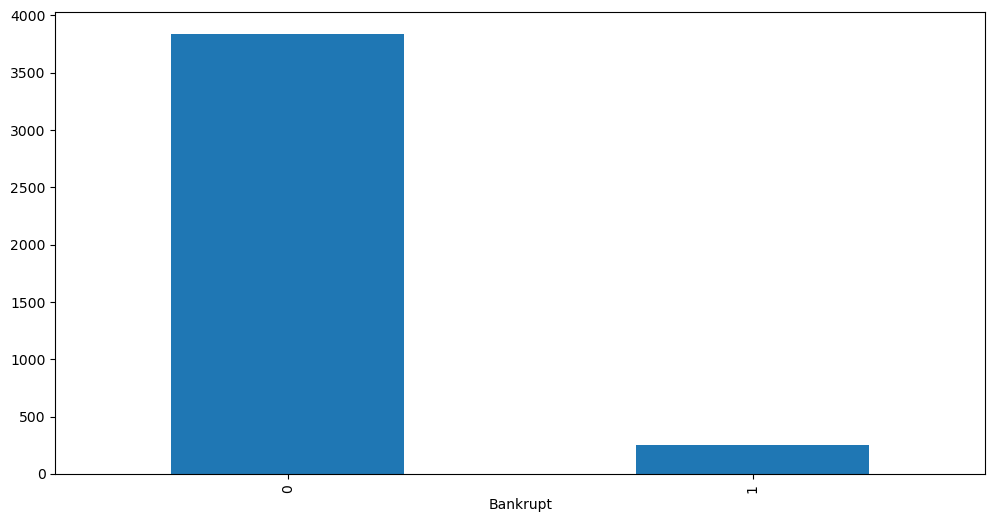

In [12]:
plt.figure()
y_train.value_counts()
y_train.value_counts().plot(kind='bar', figsize = (12, 6))
plt.show()

Based on the above bar chart, it is clear that it is an imbalanced dataset. The non-bankrupt examples are 14 times more than the bankrupt examples.

Then, let's check the distribution of the training data
- Because there are many attributes, I make two plots depending on the data scale for better analysis.

<AxesSubplot:>

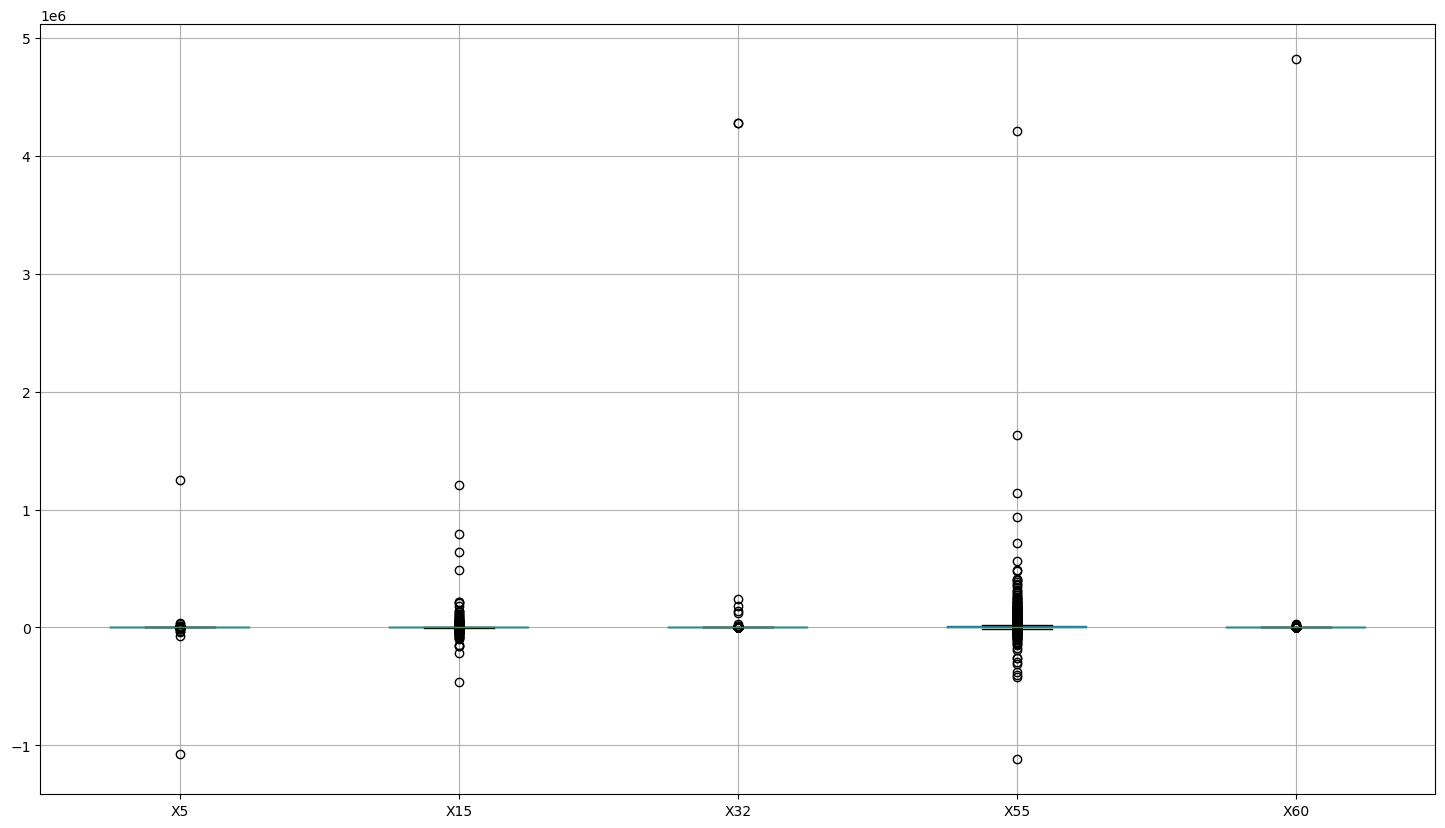

In [13]:
cols = ['X5', 'X15', 'X32', 'X55', 'X60']
X_train[cols].boxplot(figsize = (18, 10))

<AxesSubplot:>

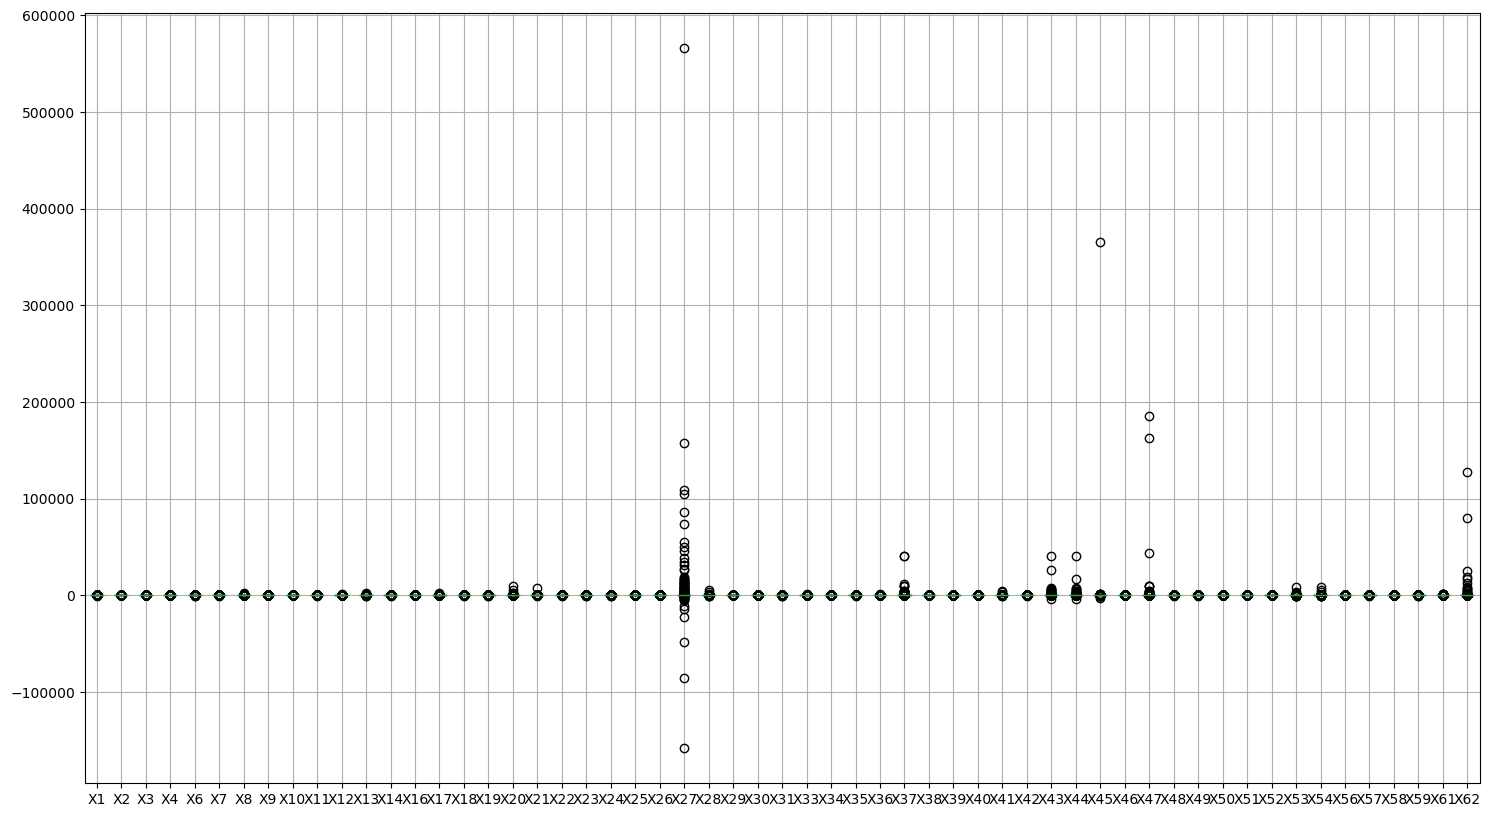

In [14]:
cols = [s for s in list(X_train.iloc[:,:-2].columns) if s not in cols]
X_train[cols].boxplot(figsize = (18, 10))

We can see there are some obvious outliners in X32, X55, X60.
- X32 (current liabilities * 365) / cost of products sold
- X55 working capital
- X60 sales / inventory

Though we don't know if the value of outliers makes sense (without further companies' information), I choose to remove them in order to avoid an outlier impact on models.

- Also, take a look at the training data that are associated with bankrupt companies.

In [15]:
X_train[y_train == 1]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
1696,0.001756,0.75316,0.201630,1.27600,4.8274,0.000000,0.002700,0.32774,2.21010,0.246840,...,1628.000,0.091515,0.007115,0.91346,0.052388,15.2640,3.0147,120.640,3.02540,32.5580
4476,-0.179050,1.25530,-0.275990,0.74554,-120.4400,-0.179050,-0.154930,-0.26018,1.17490,-0.326590,...,-58253.000,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.75590,9.9527
338,0.013272,0.79578,-0.015631,0.96943,-75.7100,0.013272,0.014109,0.12357,1.02580,0.098332,...,-1403.900,0.025109,0.134970,0.97489,2.892300,5.2512,9.7391,111.520,3.27280,3.3189
1310,-0.343470,0.74735,0.219470,1.29500,-38.4630,-0.687060,-0.343470,0.33806,2.75000,0.252650,...,132.880,-0.112310,-1.359500,1.10870,0.000000,5.1272,7.3520,98.747,3.69630,75.2370
1262,-0.118560,0.26668,0.659110,3.71540,-13.0710,-1.109900,-0.118560,2.74980,1.19140,0.733320,...,3606.000,0.270790,-0.161680,0.72950,0.000000,1.8075,6.9348,74.366,4.90810,12.1320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,-0.128150,0.33685,0.421440,3.73050,85.8720,0.000000,-0.128150,1.96870,1.18470,0.663160,...,800.740,-0.151490,-0.193240,0.87501,0.000000,58.9110,7.4376,47.552,7.67580,2.7926
2105,-0.055020,0.81037,0.022810,1.03930,-105.4300,-0.055020,-0.067794,0.11855,0.98277,0.096073,...,445.130,-0.017533,-0.572690,1.01750,2.391900,3.3382,12.5570,135.300,2.69770,3.9490
647,0.165410,2.61070,-2.184600,0.16321,-741.7300,0.165410,0.240120,-0.62911,0.73995,-1.642400,...,-21525.000,-0.351440,-0.100710,1.35140,0.000000,2.7729,15.8510,958.150,0.38094,1.7329
2090,0.024915,0.69935,0.296230,1.42360,-1.3439,-0.300740,0.024915,0.42989,0.88233,0.300640,...,54.763,-0.864100,0.082873,2.00190,0.000000,19.7380,1.2892,289.300,1.26160,199.6500


<AxesSubplot:>

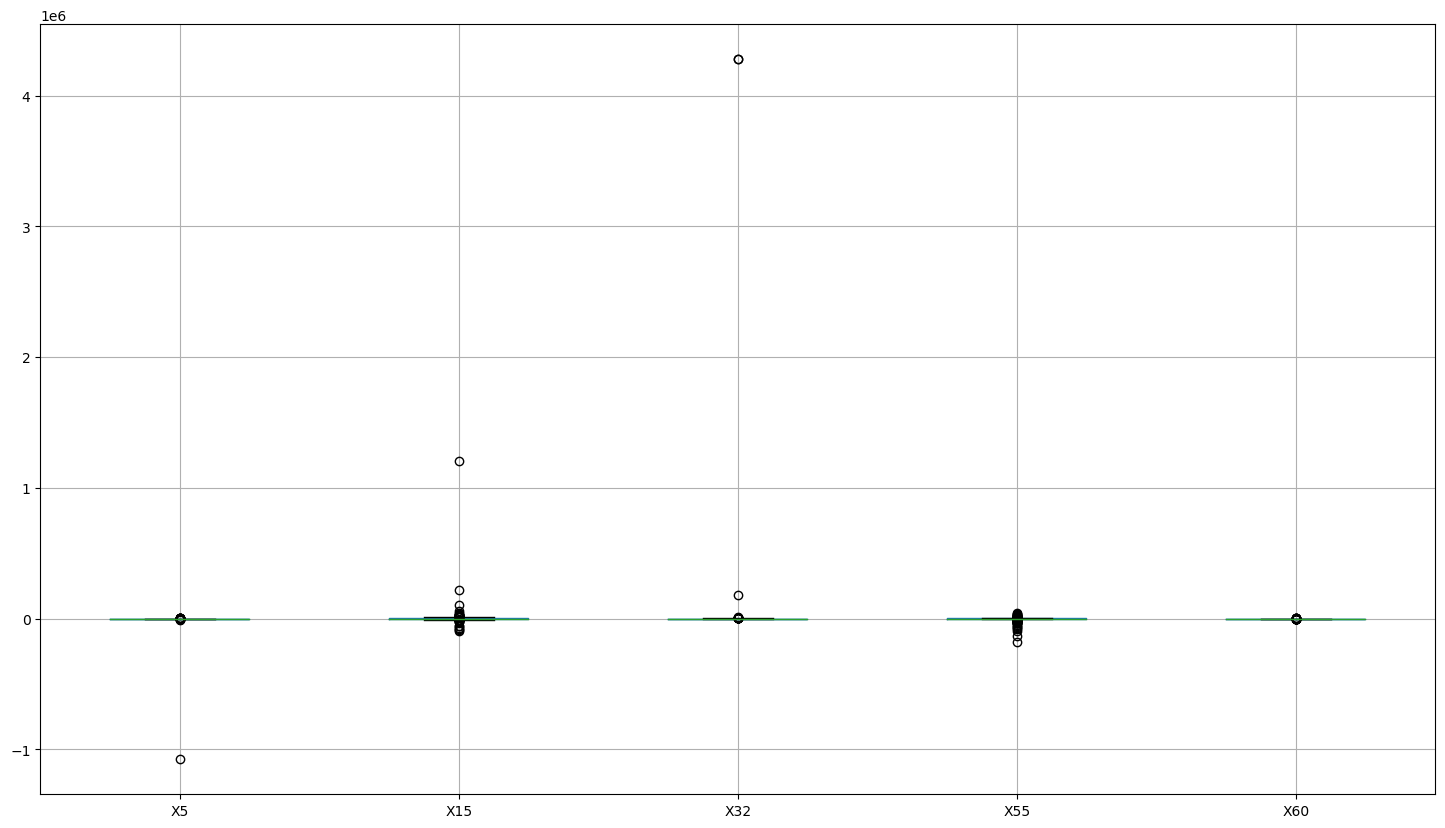

In [16]:
cols = ['X5', 'X15', 'X32', 'X55', 'X60']
X_train.loc[y_train == 1, cols].boxplot(figsize = (18, 10))

<AxesSubplot:>

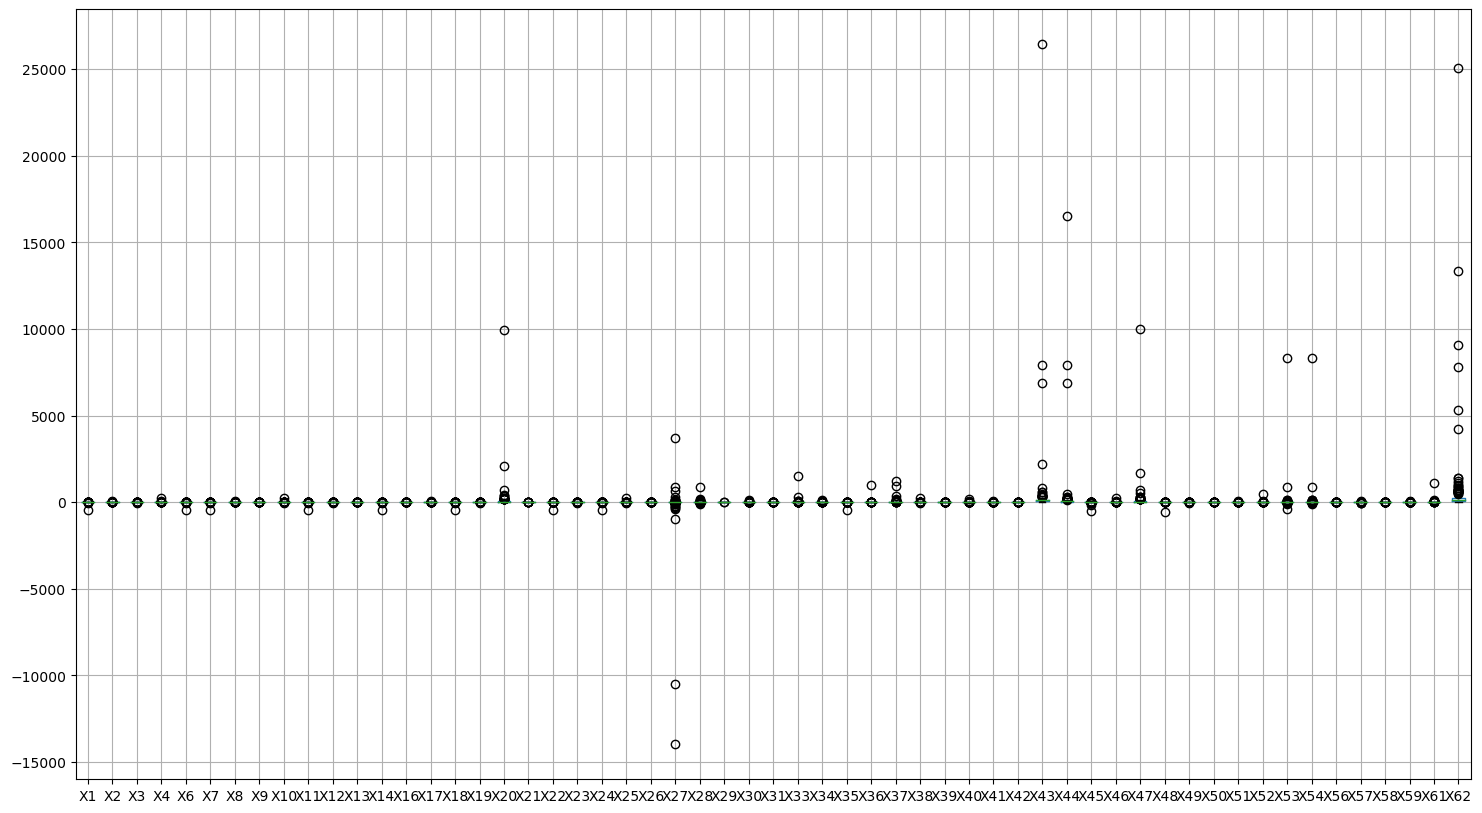

In [17]:
cols = [s for s in list(X_train.iloc[:,:-2].columns) if s not in cols]
X_train.loc[y_train == 1, cols].boxplot(figsize = (18, 10))

- Check the correlations among the atrributes

<AxesSubplot:>

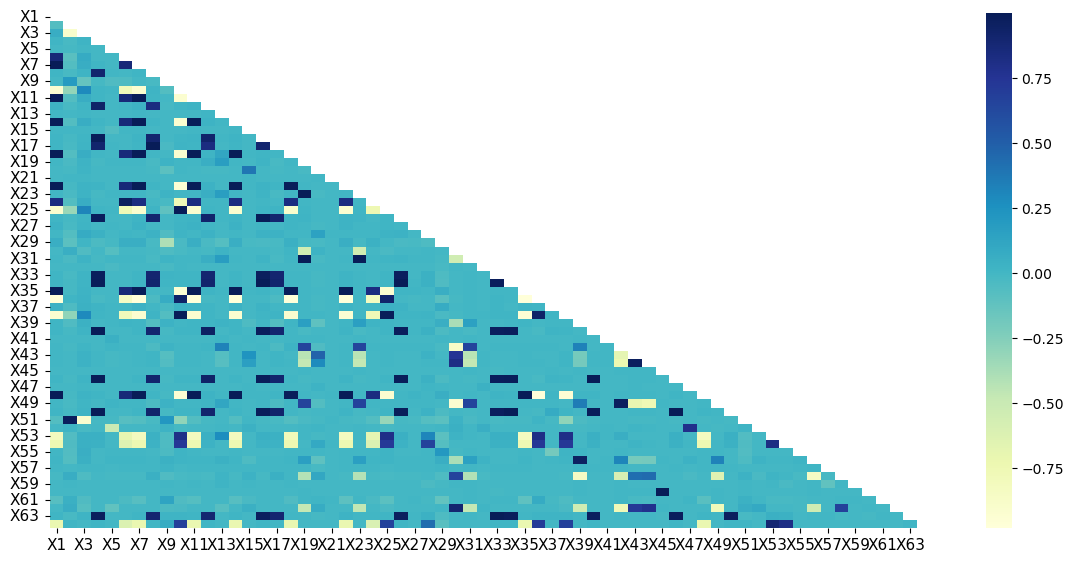

In [18]:
fig, axs = plt.subplots(1,1, figsize=[12, 6])
fig.tight_layout(pad=2.0)
mask = np.triu(np.ones_like(data.iloc[:,:-2].corr()))
sns.heatmap(data.iloc[:,:-2].corr(),
        cmap='YlGnBu',
        mask=mask,
        ax=axs);
axs.tick_params(labelsize=11)
plt.show()

The above correlation chart shows some attributes have a strong correlation. Therefore, during the model training process, I will apply a dimensionality reduction skill (principal component analysis), and see if it improves the model performance further.

# Prepare the Data

- As each row represented for each company, simple imputation (like mean or median) may cause misleading. Here, I choose to apply K-Nearest Neighbors concept for imputation.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

def transform_pipeline(x, y):
    y = np.delete(y, np.where(x > 1e6)[0], axis=0)
    x = np.delete(x, np.where(x > 1e6)[0], axis=0)
    dropAttrFunc = FunctionTransformer(lambda xx: np.delete(xx, 36, 1))
    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()
    trans_pipeline = Pipeline(steps=[ ('drop attributes', dropAttrFunc),
                                          ('imputer', imputer), 
                                          ('transform', scaler)
                                        ]
                                 )
    x = trans_pipeline.fit_transform(x)
    return x, y

In [20]:
X_train_trans, y_train_trans = transform_pipeline(X_train, y_train)
X_test_trans, y_test_trans = transform_pipeline(X_test, y_test)

# Model Training

## Method of Addressing Imbalanced Data
Instead of resampling, I assign higher weights to the minority class in the model to make the algorithm more sensitive to it. As the majority class has 14 times more data than the minority class does, I set the minority one with 14x weights. Therefore, the model will get 14x punishment when a bankruptcy sample is misclassified into the non-bankruptcy class, compared to a non-bankruptcy sample that is misclassified.

## Model without PCA

In [21]:
summary_table = pd.DataFrame(columns = ['Model', 'Accuracy', 'Recall', 'Precision'])

First, I trained 5 different models with the training data that haven't been prepocessed with PCA.

### Logistic Regression

Model: Logistic Regression avg cross validation score=0.81

Accuracy Score=0.81
Recall Score=0.67
Precision_Score=0.20


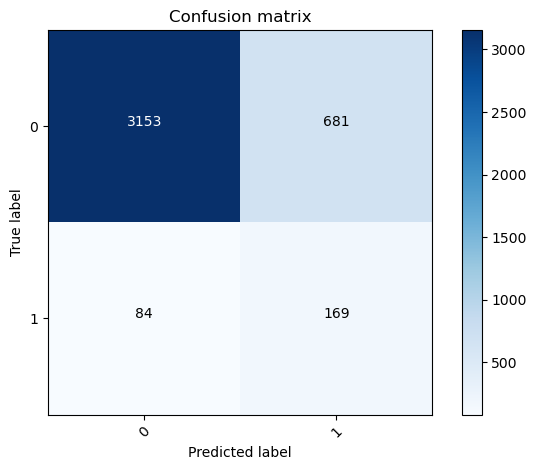

In [22]:
from sklearn.linear_model import LogisticRegression
name = 'Logistic Regression'
clf = LogisticRegression(solver='liblinear',  class_weight = {0:1, 1:14})
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_trans, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Decision Tree Classifier

Model: Decision Tree Classifier avg cross validation score=0.77

Accuracy Score=0.77
Recall Score=0.64
Precision_Score=0.16


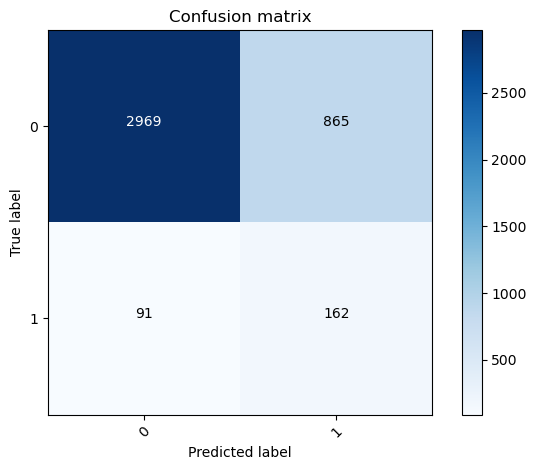

In [23]:
from sklearn.tree import DecisionTreeClassifier
name = 'Decision Tree Classifier'
clf = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight = {0:1, 1:14})
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_trans, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Random Forest Classifier

Model: Random Forest Classifier avg cross validation score=0.91

Accuracy Score=0.91
Recall Score=0.45
Precision_Score=0.34


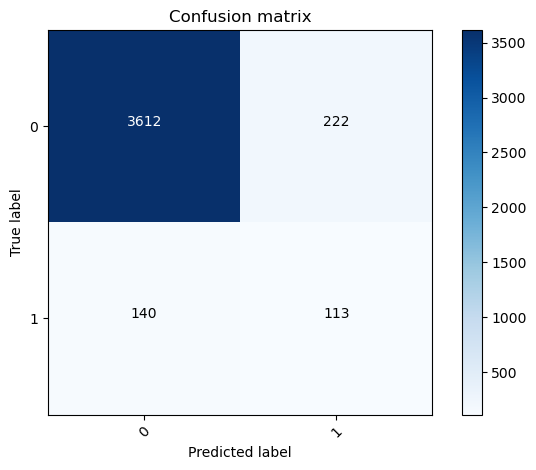

In [24]:
from sklearn.ensemble import RandomForestClassifier
name = 'Random Forest Classifier'
clf = RandomForestClassifier(max_depth=5, random_state=42, class_weight = {0:1, 1:14})
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_trans, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Gradient Boosting Classifier

Model: Gradient Boosting Classifier avg cross validation score=0.92

Accuracy Score=0.92
Recall Score=0.28
Precision_Score=0.34


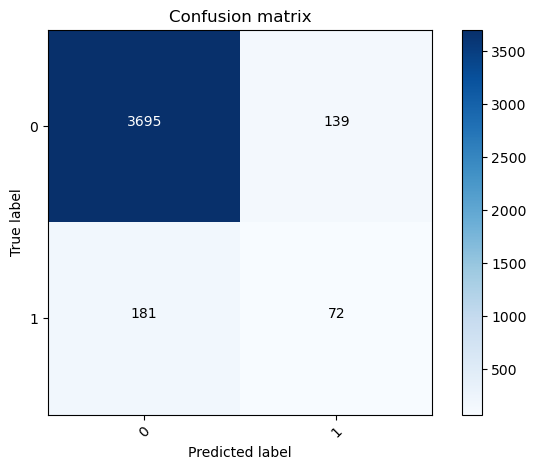

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
name = 'Gradient Boosting Classifier'
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=3, 
                                 random_state=0)
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_trans, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Ada Boost Classifier

Model: Ada Boost Classifier avg cross validation score=0.92

Accuracy Score=0.92
Recall Score=0.41
Precision_Score=0.35


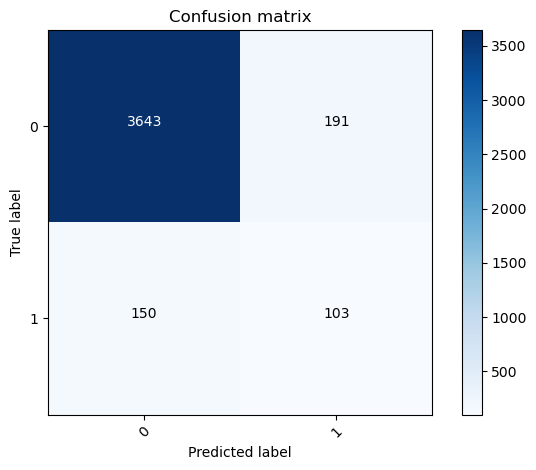

In [26]:
from sklearn.ensemble import AdaBoostClassifier
name = 'Ada Boost Classifier'
clf = AdaBoostClassifier(n_estimators=50, random_state=0, 
    base_estimator = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight = {0:1, 1:14}))
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_trans, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

## Model with PCA

When reviewing the 64 features, we can find they should be correlated because their definitions are based on only a few accounting subjects. Thus, in this section, I trained the same 5 models with the training data preprocessed by PCA, and see whether the results improve due to eliminating collinearity.

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
X_train_pca = X_train_trans.copy()
X_train_pca = pca.fit_transform(X_train_pca)

In [28]:
X_train_pca.shape

(4087, 31)

### Logistic Regression

Model: Logistic Regression (PCA) avg cross validation score=0.80

Accuracy Score=0.80
Recall Score=0.64
Precision_Score=0.18


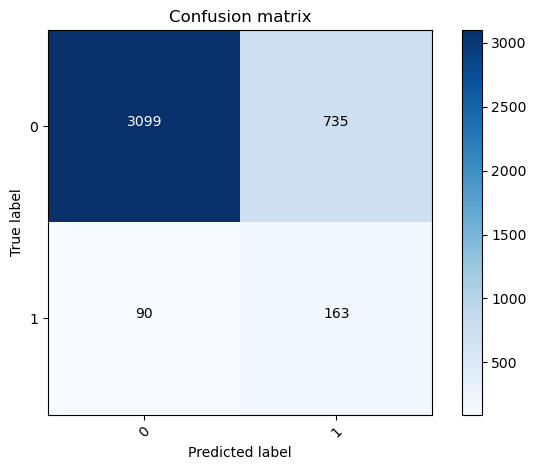

In [29]:
name = 'Logistic Regression (PCA)'
clf = LogisticRegression(solver='liblinear', class_weight = {0:1, 1:14})
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_pca, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Decision Tree Classifier

Model: Decision Tree Classifier (PCA) avg cross validation score=0.70

Accuracy Score=0.70
Recall Score=0.75
Precision_Score=0.14


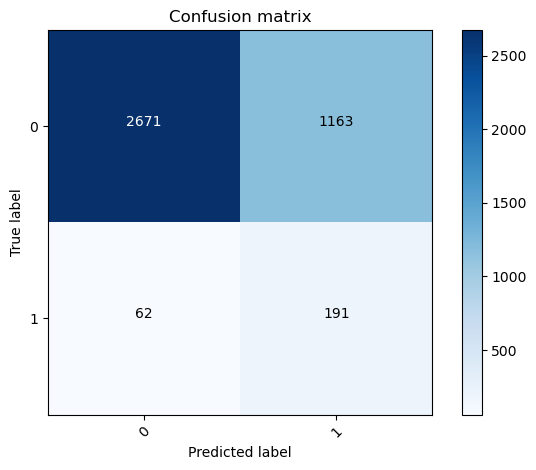

In [30]:
name = 'Decision Tree Classifier (PCA)'
clf = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight = {0:1, 1:14})
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_pca, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Random Forest Classifier

Model: Random Forest Classifier (PCA) avg cross validation score=0.83

Accuracy Score=0.83
Recall Score=0.68
Precision_Score=0.22


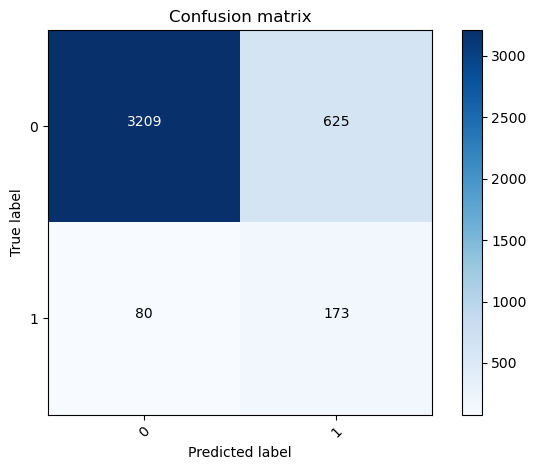

In [31]:
name = 'Random Forest Classifier (PCA)'
clf = RandomForestClassifier(max_depth=2, random_state=42, class_weight = {0:1, 1:14})
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_pca, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Gradient Boosting Classifier

Model: Gradient Boosting Classifier (PCA) avg cross validation score=0.92

Accuracy Score=0.92
Recall Score=0.19
Precision_Score=0.26


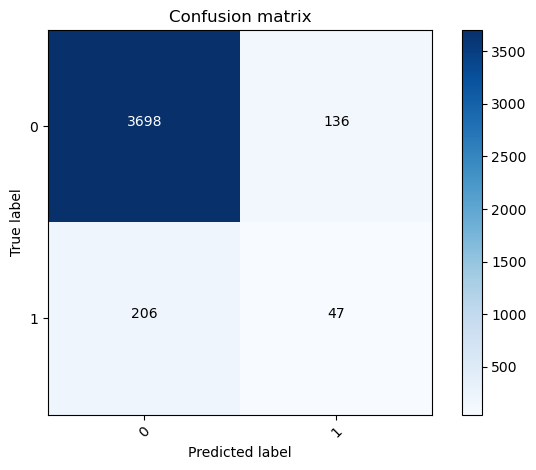

In [32]:
name = 'Gradient Boosting Classifier (PCA)'
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=3, 
                                 random_state=0)
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_pca, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

### Ada Boost Classifier

Model: Ada Boost Classifier (PCA) avg cross validation score=0.88

Accuracy Score=0.88
Recall Score=0.35
Precision_Score=0.22


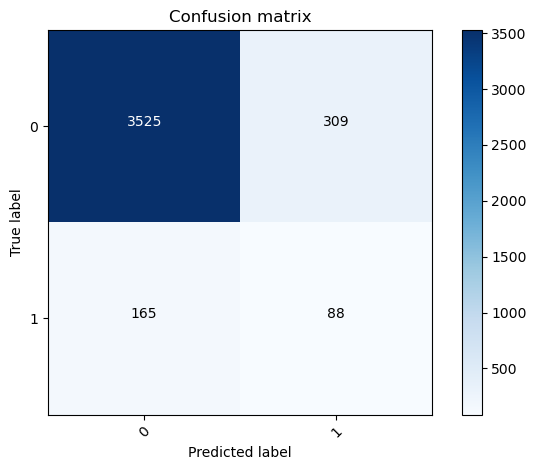

In [33]:
name = 'Ada Boost Classifier (PCA)'
clf = AdaBoostClassifier(n_estimators=50, random_state=0, 
    base_estimator = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight = {0:1, 1:14}))
accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_pca, y_train_trans)
summary_table = hp.record_in_summary(summary_table, name, accuracy_s, recall_s, precision_s)

Let's take a look at the summary table to compare the model preformances.

In [34]:
summary_table

,Model,Accuracy,Recall,Precision
0,Logistic Regression,0.812821,0.667984,0.198824
1,Decision Tree Classifier,0.766088,0.640316,0.157741
2,Random Forest Classifier,0.911426,0.446640,0.337313
3,Gradient Boosting Classifier,0.921703,0.284585,0.341232
4,Ada Boost Classifier,0.916565,0.407115,0.350340
5,Logistic Regression (PCA),0.798140,0.644269,0.181514
6,Decision Tree Classifier (PCA),0.700269,0.754941,0.141064
7,Random Forest Classifier (PCA),0.827502,0.683794,0.216792
8,Gradient Boosting Classifier (PCA),0.916320,0.185771,0.256831
9,Ada Boost Classifier (PCA),0.884023,0.347826,0.221662


## Fine-Tuned

- According to the above table, we can find only Random Forest Classifier (without PCA) and	Ada Boost Classifier (without PCA) have overall scores of more than 0.3. I will choose the two models to fine-tune and see whether the model can be improved.
- Also, the PCA process didn't significantly improve the performance, but I still choose "Decision Tree Classifier (PCA)", the one with relatively higher accuracy and recall score, to fine-tune.

### Random Forest Classifier (without PCA)

In [35]:
def summary_table_tree(summary_table, name, accuracy_s, recall_s, precision_s, 
                         max_depth, class_weight, criterion):
    
    row = pd.DataFrame({'Model':name, 'Accuracy':accuracy_s, 
                        'Recall':recall_s, 'Precision':precision_s,
                        'Max Depth':max_depth, 'Class Weight': class_weight,
                        'Criterion': criterion}, index = [0])
    summary_table = pd.concat([summary_table, row], ignore_index = True)
    return summary_table

In [36]:
summary_table_RFC = pd.DataFrame(columns = ['Model', 'Accuracy', 'Recall', 
                                              'Precision','Max Depth', 'Class Weight', 'Criterion'])

In [37]:
name = 'Random Forest Classifier'
max_depth_list = [3, 5, 10]
class_weight_list = [{0:1, 1:5}, {0:1, 1:14}, {0:1, 1:30}]
criterion_list = ['gini', 'entropy', 'log_loss']
for md, cw, cl in itertools.product(max_depth_list, class_weight_list, criterion_list):
    clf = RandomForestClassifier(criterion = cl, max_depth=md, random_state=42, class_weight = cw)
    accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_trans, y_train_trans, display = False)
    summary_table_RFC = summary_table_tree(summary_table_RFC, name, accuracy_s, recall_s, 
                                            precision_s, md, str(cw), cl)


In [38]:
summary_table_RFC

,Model,Accuracy,Recall,Precision,Max Depth,Class Weight,Criterion
0,Random Forest Classifier,0.925618,0.391304,0.397590,3,"{0: 1, 1: 5}",gini
1,Random Forest Classifier,0.925128,0.403162,0.396887,3,"{0: 1, 1: 5}",entropy
2,Random Forest Classifier,0.925128,0.403162,0.396887,3,"{0: 1, 1: 5}",log_loss
3,Random Forest Classifier,0.878395,0.596838,0.276557,3,"{0: 1, 1: 14}",gini
4,Random Forest Classifier,0.878150,0.588933,0.274401,3,"{0: 1, 1: 14}",entropy
5,Random Forest Classifier,0.878150,0.588933,0.274401,3,"{0: 1, 1: 14}",log_loss
6,Random Forest Classifier,0.726450,0.754941,0.153168,3,"{0: 1, 1: 30}",gini
7,Random Forest Classifier,0.724248,0.750988,0.151515,3,"{0: 1, 1: 30}",entropy
8,Random Forest Classifier,0.724248,0.750988,0.151515,3,"{0: 1, 1: 30}",log_loss
9,Random Forest Classifier,0.931001,0.324111,0.424870,5,"{0: 1, 1: 5}",gini


### Ada Boost Classifier (without PCA)

In [39]:
def summary_table_abc(summary_table, name, accuracy_s, recall_s, precision_s, 
                         n_estimators, max_depth, class_weight):
    
    row = pd.DataFrame({'Model':name, 'Accuracy':accuracy_s, 
                        'Recall':recall_s, 'Precision':precision_s, 
                        'N Estimators': n_estimators,
                        'Max Depth':max_depth, 'Class Weight': class_weight}, index = [0])
    summary_table = pd.concat([summary_table, row], ignore_index = True)
    return summary_table

In [40]:
summary_table_ABC = pd.DataFrame(columns = ['Model', 'Accuracy', 'Recall', 'Precision',
                                            'N Estimators', 'Max Depth', 'Class Weight'])

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

name = 'Ada Boost Classifier'
n_estimators_list = [50, 70]
max_depth_list = [1, 3, 5]
class_weight_list = [{0:1, 1:5}, {0:1, 1:15}, {0:1, 1:30}]
for n_est, md, cw in itertools.product(n_estimators_list, max_depth_list, class_weight_list):
    clf = AdaBoostClassifier(n_estimators=n_est, random_state=0, 
                             base_estimator = DecisionTreeClassifier(max_depth=md, random_state=42, class_weight = cw))
    accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_trans, y_train_trans, display=False)
    summary_table_ABC = summary_table_abc(summary_table_ABC, name, accuracy_s, recall_s, 
                                            precision_s, n_est, md, str(cw))

In [42]:
summary_table_ABC

,Model,Accuracy,Recall,Precision,N Estimators,Max Depth,Class Weight
0,Ada Boost Classifier,0.902373,0.415020,0.294944,50,1,"{0: 1, 1: 5}"
1,Ada Boost Classifier,0.859065,0.577075,0.237398,50,1,"{0: 1, 1: 15}"
2,Ada Boost Classifier,0.805481,0.667984,0.192045,50,1,"{0: 1, 1: 30}"
3,Ada Boost Classifier,0.931245,0.284585,0.418605,50,3,"{0: 1, 1: 5}"
4,Ada Boost Classifier,0.931979,0.276680,0.424242,50,3,"{0: 1, 1: 15}"
5,Ada Boost Classifier,0.926107,0.268775,0.367568,50,3,"{0: 1, 1: 30}"
6,Ada Boost Classifier,0.934426,0.134387,0.409639,50,5,"{0: 1, 1: 5}"
7,Ada Boost Classifier,0.937852,0.189723,0.494845,50,5,"{0: 1, 1: 15}"
8,Ada Boost Classifier,0.935894,0.185771,0.456311,50,5,"{0: 1, 1: 30}"
9,Ada Boost Classifier,0.908735,0.391304,0.311321,70,1,"{0: 1, 1: 5}"


### Decision Tree Classifier (with PCA)

In [43]:
summary_table_DTC = pd.DataFrame(columns = ['Model', 'Accuracy', 'Recall', 
                                              'Precision','Max Depth', 'Class Weight', 'Criterion'])

In [44]:
name = 'Decision Tree Classifier (PCA)'
max_depth_list = [3, 5, 10]
class_weight_list = [{0:1, 1:5}, {0:1, 1:15}, {0:1, 1:30}]
criterion_list = ['gini', 'entropy', 'log_loss']
for md, cw, cl in itertools.product(max_depth_list, class_weight_list, criterion_list):
    clf = DecisionTreeClassifier(criterion=cl, max_depth=md, random_state=42, class_weight = cw)
    accuracy_s, recall_s, precision_s = hp.Evaluate_Model(name, clf, X_train_pca, y_train_trans, display = False)
    summary_table_DTC = summary_table_tree(summary_table_DTC, name, accuracy_s, recall_s, 
                                            precision_s, md, str(cw), cl)

In [45]:
summary_table_DTC

,Model,Accuracy,Recall,Precision,Max Depth,Class Weight,Criterion
0,Decision Tree Classifier (PCA),0.889650,0.426877,0.260870,3,"{0: 1, 1: 5}",gini
1,Decision Tree Classifier (PCA),0.886959,0.418972,0.251781,3,"{0: 1, 1: 5}",entropy
2,Decision Tree Classifier (PCA),0.886959,0.418972,0.251781,3,"{0: 1, 1: 5}",log_loss
3,Decision Tree Classifier (PCA),0.770981,0.604743,0.154702,3,"{0: 1, 1: 15}",gini
4,Decision Tree Classifier (PCA),0.677025,0.707510,0.125614,3,"{0: 1, 1: 15}",entropy
5,Decision Tree Classifier (PCA),0.677025,0.707510,0.125614,3,"{0: 1, 1: 15}",log_loss
6,Decision Tree Classifier (PCA),0.581845,0.849802,0.113998,3,"{0: 1, 1: 30}",gini
7,Decision Tree Classifier (PCA),0.632004,0.802372,0.122511,3,"{0: 1, 1: 30}",entropy
8,Decision Tree Classifier (PCA),0.632004,0.802372,0.122511,3,"{0: 1, 1: 30}",log_loss
9,Decision Tree Classifier (PCA),0.878150,0.411067,0.229581,5,"{0: 1, 1: 5}",gini


## Evaluation based on Test Data

The following tables show the performance with the highest recall scores of each model under differet parameters.

In [46]:
summary_table_RFC.nlargest(5, 'Recall')
summary_table_ABC.nlargest(5, 'Recall')
summary_table_DTC.nlargest(5, 'Recall')

,Model,Accuracy,Recall,Precision,Max Depth,Class Weight,Criterion
6,Random Forest Classifier,0.726450,0.754941,0.153168,3,"{0: 1, 1: 30}",gini
7,Random Forest Classifier,0.724248,0.750988,0.151515,3,"{0: 1, 1: 30}",entropy
8,Random Forest Classifier,0.724248,0.750988,0.151515,3,"{0: 1, 1: 30}",log_loss
15,Random Forest Classifier,0.857842,0.624506,0.245342,5,"{0: 1, 1: 30}",gini
16,Random Forest Classifier,0.852948,0.612648,0.235562,5,"{0: 1, 1: 30}",entropy


,Model,Accuracy,Recall,Precision,N Estimators,Max Depth,Class Weight
2,Ada Boost Classifier,0.805481,0.667984,0.192045,50,1,"{0: 1, 1: 30}"
11,Ada Boost Classifier,0.825544,0.644269,0.207379,70,1,"{0: 1, 1: 30}"
1,Ada Boost Classifier,0.859065,0.577075,0.237398,50,1,"{0: 1, 1: 15}"
10,Ada Boost Classifier,0.865427,0.545455,0.240838,70,1,"{0: 1, 1: 15}"
0,Ada Boost Classifier,0.902373,0.415020,0.294944,50,1,"{0: 1, 1: 5}"


,Model,Accuracy,Recall,Precision,Max Depth,Class Weight,Criterion
6,Decision Tree Classifier (PCA),0.581845,0.849802,0.113998,3,"{0: 1, 1: 30}",gini
7,Decision Tree Classifier (PCA),0.632004,0.802372,0.122511,3,"{0: 1, 1: 30}",entropy
8,Decision Tree Classifier (PCA),0.632004,0.802372,0.122511,3,"{0: 1, 1: 30}",log_loss
4,Decision Tree Classifier (PCA),0.677025,0.707510,0.125614,3,"{0: 1, 1: 15}",entropy
5,Decision Tree Classifier (PCA),0.677025,0.707510,0.125614,3,"{0: 1, 1: 15}",log_loss


If I am an investor and would like to seek some companies for my investment, I will choose the model with as a high recall as possible. This is because if I invest in a company that is going to be bankrupt, I will possibly need 10-20 times more successful investments to make up for my loss. Therefore, I will choose the Random Forest Classifier with Max Depth=3, Class Weight={0: 1, 1: 30}, Criterion='gini'.

Accuracy Score=0.73
Recall Score=0.81
Precision_Score=0.19


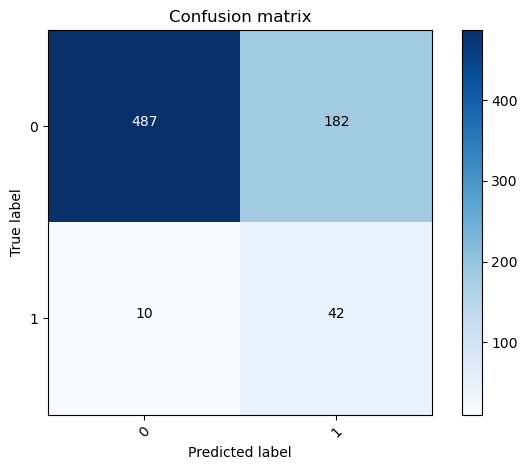

In [47]:

import pandas as pd
import os

clf_final = RandomForestClassifier(criterion = 'gini', max_depth = 3, random_state=42, 
                                   class_weight = {0:1, 1:30})
_ = clf_final.fit(X_train_trans, y_train_trans)
y_pred = clf_final.predict(X_test_trans)
accuracy_s = accuracy_score(y_test_trans, y_pred)
recall_s = recall_score(y_test_trans, y_pred, pos_label=1, average="binary")
precision_s = precision_score(y_test_trans, y_pred, pos_label=1, average="binary")

print('Accuracy Score={s:3.2f}'.format(s=accuracy_s))
print('Recall Score={s:3.2f}'.format(s=recall_s))
print('Precision_Score={s:3.2f}'.format(s=precision_s))

confusion_mat = metrics.confusion_matrix(y_test_trans, y_pred)
hp.plot_confusion_matrix(confusion_mat, [0,1])


The accuracy and recall scores achieved 0.73 and 0.81 respectively. It's a pretty good result! However, the precision score is only about 0.19, which we want to improve further. If we can obtain more attributes in addition to the financial information, the model will possibly give a better prediction and performance.

In [48]:
print('Done')

Done
